# <font style="color:rgb(50,120,229)"> Optimizadores en Keras </font>

Hasta ahora en el curso, hemos utilizado varios optimizadores para entrenar modelos y revisado la teoría de cuatro tipos diferentes (SGD, SGD + Momentum, RMSProp y Adam). `tf.keras.optimizers` es un módulo de TensorFlow donde se implementan varios algoritmos de optimización.

Puedes encontrar la documentación oficial [aquí](https://keras.io/api/optimizers/).


En este cuaderno, compararemos cuatro optimizadores diferentes utilizando el modelo LeNet5 y el conjunto de datos Fashion MNIST.

Entrenaremos el modelo cuatro veces usando un optimizador diferente en cada caso, utilizando la tasa de aprendizaje predeterminada para cada optimizador y trazaremos la **pérdida** de entrenamiento para tener una mejor idea de las propiedades de convergencia de cada optimizador.


In [1]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_loss(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [2]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
NUM_CLASSES = 10

BATCH_SIZE = 64
EPOCHS = 101
LEARNING_RATE = 0.001
ROOT_CHECKPOINT_DIR = "optimizer_saved_models"

# <font style="color:rgb(50,120,229)"> 1. Cargar el conjunto de datos Fashion MNIST </font>


In [3]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Preprocesaremos los datos para convertirlos en tensores y aplicamos one-hot encoding a las etiquetas.

In [5]:
from keras.utils import to_categorical

def preprocess_data(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape(-1, HEIGHT, WIDTH, CHANNELS)
    X_test = X_test.reshape(-1, HEIGHT, WIDTH, CHANNELS)

    y_train = to_categorical(y_train, NUM_CLASSES)
    y_test = to_categorical(y_test, NUM_CLASSES)

    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = preprocess_data(X_train, y_train, X_test, y_test)

## <font style="color:rgb(50,120,229)"> 2. Visualizar algunas imágenes </font>

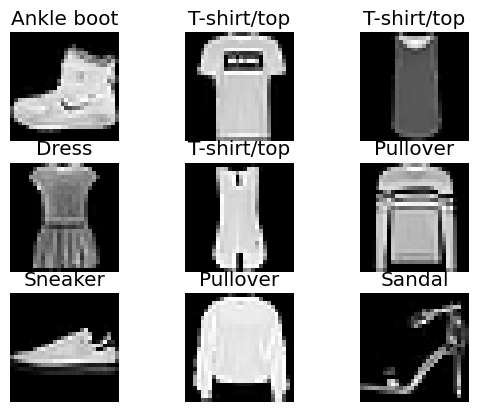

In [7]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = X_train[i]
    label = class_names[y_train[i].argmax()]

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()

## <font style="color:rgb(50,120,229)"> 3. Definir el modelo LeNet5 </font>

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Resizing, Rescaling

def build_model():
    input_layer = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    resizig = Resizing(32, 32)(input_layer)
    rescaling = Rescaling(1./255)(resizig)

    conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(rescaling)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    flatten = Flatten()(pool2)

    hidden1 = Dense(128, activation='relu')(flatten)
    output_layer = Dense(NUM_CLASSES, activation='softmax')(hidden1)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

## <font style="color:rgb(50,120,229)"> 4. Definir el entrenamiento </font>

Hasta ahora solo habiamos creado un optimizador pasando como argumento el nombre del optimizador al método `compile`.

Tambien podemos crear un objeto de optimizador y pasarlo al método `compile`.

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
```

In [9]:
from keras.optimizers import Adam, SGD, RMSprop

def build_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'momentum':
        return SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError('Unknown optimizer')

In [10]:
from keras.callbacks import EarlyStopping

def train_model(model, train_data, validation_data, optimizer_name):
    optimizer = build_optimizer(optimizer_name, LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(patience=5, verbose=1)

    history = model.fit(
        train_data[0], train_data[1],
        validation_data=validation_data,
        batch_size=BATCH_SIZE,
        epochs=5,
        verbose=1,
        callbacks=[early_stopping]
    )

    return history

## <font style="color:rgb(50,120,229)"> 5. Entrenar el modelo </font>

### <font style="color:rgb(50,120,229)"> 5.1. Entrenar con SGD </font>

Regla de actualización del descenso de gradiente:

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

donde,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n}
         \end{bmatrix}
$$

Para la actualización del descenso de gradiente estocástico, usamos el siguiente método en TensorFlow:

```python
tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs
)
```

**Parámetros:**


- `learning_rate` – Un Tensor, valor de punto flotante, o un horario que sea `tf.keras.optimizers.schedules.LearningRateSchedule`, o un callable que no toma argumentos y devuelve el valor real a usar. La tasa de aprendizaje. Por defecto es 0.01.

- `momentum` – hiperparámetro flotante >= 0 que acelera el descenso de gradiente en la dirección relevante y amortigua las oscilaciones. Por defecto es 0, es decir, descenso de gradiente simple.

- `nesterov` – booleano. Si se aplica el momentum de Nesterov. Por defecto es `False`.

- `name` – Prefijo de nombre opcional para las operaciones creadas al aplicar gradientes. Por defecto es "SGD".

- `**kwargs` – Argumentos clave. Permitido ser uno de "clipnorm" o "clipvalue". "clipnorm" (float) recorta los gradientes por norma; "clipvalue" (float) recorta los gradientes por valor.

In [11]:
lenet = build_model()

train_data = (X_train, y_train)
validation_data = (X_test, y_test)

sgd_history = train_model(lenet, train_data, validation_data, 'sgd')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 169s 180ms/step - accuracy: 0.2322 - loss: 2.2571 - val_accuracy: 0.4666 - val_loss: 2.0469
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 210s 189ms/step - accuracy: 0.5115 - loss: 1.8204 - val_accuracy: 0.6239 - val_loss: 1.0963
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 193s 179ms/step - accuracy: 0.6533 - loss: 1.0029 - val_accuracy: 0.6804 - val_loss: 0.8721
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 204s 181ms/step - accuracy: 0.6996 - loss: 0.8269 - val_accuracy: 0.7086 - val_loss: 0.7999
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 166s 177ms/step - accuracy: 0.7215 - loss: 0.7662 - val_accuracy: 0.7197 - val_loss: 0.7630


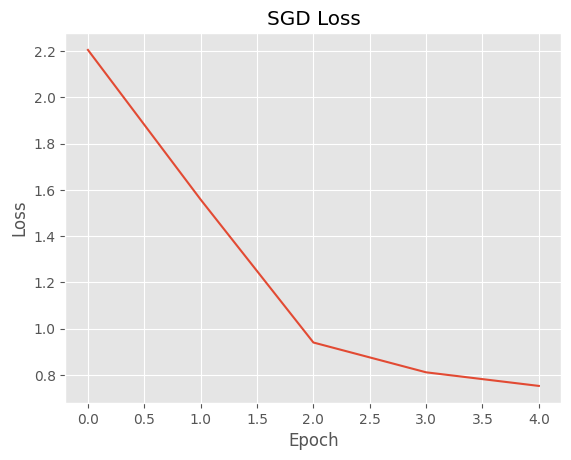

In [12]:
plot_loss(sgd_history.history['loss'], 'SGD Loss')

### <font style="color:rgb(50,120,229)"> 5.2. Entrenar con SGD + Momentum </font>

Regla de actualización del descenso de gradiente con momento:

$$
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}
$$

En TensorFlow, usamos `tf.keras.optimizers.SGD` con un valor de momentum distinto de cero.

En el siguiente entrenamiento, utilizaremos $\beta = 0.9$. Aquí, $\beta$ es el momentum.

In [13]:
lenet = build_model()
momentum_history = train_model(lenet, train_data, validation_data, 'momentum')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 160s 169ms/step - accuracy: 0.4330 - loss: 1.5951 - val_accuracy: 0.6981 - val_loss: 0.7476
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 214s 182ms/step - accuracy: 0.7572 - loss: 0.6556 - val_accuracy: 0.7829 - val_loss: 0.5928
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 160s 170ms/step - accuracy: 0.7973 - loss: 0.5529 - val_accuracy: 0.8184 - val_loss: 0.5143
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 209s 178ms/step - accuracy: 0.8215 - loss: 0.4924 - val_accuracy: 0.8286 - val_loss: 0.4820
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 171s 183ms/step - accuracy: 0.8343 - loss: 0.4545 - val_accuracy: 0.8321 - val_loss: 0.4656


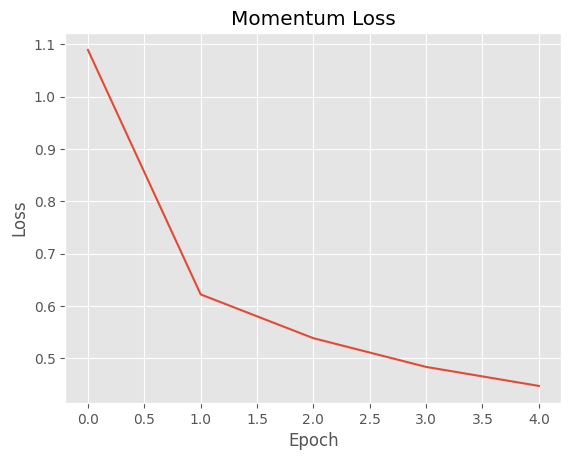

In [14]:
plot_loss(momentum_history.history['loss'], 'Momentum Loss')

### <font style="color:rgb(50,120,229)"> 5.3. Entrenar con RMSProp </font>

Regla de actualización de RMSProp:

$$
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt{s_t} + \epsilon} \\
\end{align}
$$

Para la actualización de pesos con RMSProp, usamos el siguiente método en TensorFlow:


```python
tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop', **kwargs
)
```

**Parámetros:**

- `learning_rate` – Un Tensor, valor de punto flotante, o un horario que sea `tf.keras.optimizers.schedules.LearningRateSchedule`, o un callable que no toma argumentos y devuelve el valor real a usar. La tasa de aprendizaje. Por defecto es 0.001.

- `rho` – Factor de descuento para el historial/próximo gradiente. Por defecto es 0.9.

- `momentum` – Un escalar o un Tensor escalar. Por defecto es 0.0.

- `epsilon` – Una pequeña constante para la estabilidad numérica. Este epsilon es "epsilon hat" en el documento de Kingma y Ba (en la fórmula justo antes de la Sección 2.1), no el epsilon en el Algoritmo 1 del documento. Por defecto es 1e-7.

- `centered` – Booleano. Si es `True`, los gradientes se normalizan por la varianza estimada del gradiente; si es False, por el segundo momento no centrado. Establecer esto en True puede ayudar con el entrenamiento, pero es ligeramente más costoso en términos de computación y memoria. Por defecto es `False`.

- `name` – Prefijo de nombre opcional para las operaciones creadas al aplicar gradientes. Por defecto es "`RMSprop`".

- `**kwargs` – Argumentos clave. Permitido ser uno de "`clipnorm`" o "`clipvalue`". "`clipnorm`" (float) recorta los gradientes por norma; "`clipvalue`" (float) recorta los gradientes por valor.


In [15]:
lenet = build_model()
rmsprop_history = train_model(lenet, train_data, validation_data, 'rmsprop')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 168s 179ms/step - accuracy: 0.7525 - loss: 0.6840 - val_accuracy: 0.8613 - val_loss: 0.3777
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 206s 183ms/step - accuracy: 0.8812 - loss: 0.3241 - val_accuracy: 0.8792 - val_loss: 0.3407
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 165s 177ms/step - accuracy: 0.8990 - loss: 0.2757 - val_accuracy: 0.8956 - val_loss: 0.2824
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 200s 174ms/step - accuracy: 0.9113 - loss: 0.2442 - val_accuracy: 0.8949 - val_loss: 0.2907
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 202s 174ms/step - accuracy: 0.9193 - loss: 0.2163 - val_accuracy: 0.9036 - val_loss: 0.2715


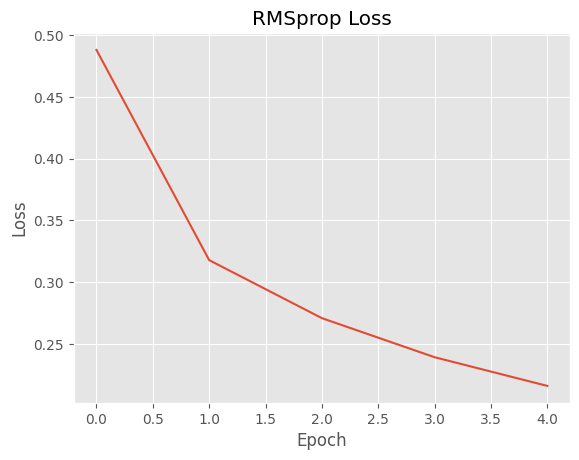

In [16]:
plot_loss(rmsprop_history.history['loss'], 'RMSprop Loss')

### <font style="color:rgb(50,120,229)"> 5.4. Entrenar con Adam </font>

Regla de actualización de Adam:

$$
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt{s_t} + \epsilon} \\
\end{align}
$$

Para la actualización de pesos con Adam, usamos el siguiente método en TensorFlow:

```python
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', **kwargs
)
```

- `learning_rate` – Un Tensor, valor de punto flotante, o un horario que es `tf.keras.optimizers.schedules.LearningRateSchedule`, o un callable que no toma argumentos y devuelve el valor real a usar. La tasa de aprendizaje. Por defecto es 0.001.

- `beta_1` – Un valor flotante o un tensor flotante constante, o un callable que no toma argumentos y devuelve el valor real a usar. La tasa de decaimiento exponencial para las estimaciones del primer momento. Por defecto es 0.9.

- `beta_2` – Un valor flotante o un tensor flotante constante, o un callable que no toma argumentos y devuelve el valor real a usar. La tasa de decaimiento exponencial para las estimaciones del segundo momento. Por defecto es 0.999.

- `epsilon` – Una pequeña constante para la estabilidad numérica. Este epsilon es "epsilon hat" en el documento de Kingma y Ba (en la fórmula justo antes de la Sección 2.1), no el epsilon en el Algoritmo 1 del documento. Por defecto es 1e-7.

- `amsgrad` – Booleano. Si se aplica la variante AMSGrad de este algoritmo del documento "Sobre la convergencia de Adam y más allá". Por defecto es `False`.

- `name` - Nombre opcional para las operaciones creadas al aplicar gradientes. Por defecto es "Adam".

- `**kwargs` – Argumentos clave. Permitido ser uno de "`clipnorm`" o "`clipvalue`". "`clipnorm`" (float) recorta los gradientes por norma; "`clipvalue`" (float) recorta los gradientes por valor.


In [17]:
lenet = build_model()
adam_history = train_model(lenet, train_data, validation_data, 'adam')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 160s 170ms/step - accuracy: 0.7589 - loss: 0.6703 - val_accuracy: 0.8593 - val_loss: 0.3817
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 215s 183ms/step - accuracy: 0.8789 - loss: 0.3312 - val_accuracy: 0.8855 - val_loss: 0.3170
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 189s 171ms/step - accuracy: 0.8983 - loss: 0.2813 - val_accuracy: 0.8894 - val_loss: 0.2941
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 211s 181ms/step - accuracy: 0.9082 - loss: 0.2469 - val_accuracy: 0.9016 - val_loss: 0.2672
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 191s 170ms/step - accuracy: 0.9190 - loss: 0.2154 - val_accuracy: 0.9071 - val_loss: 0.2570


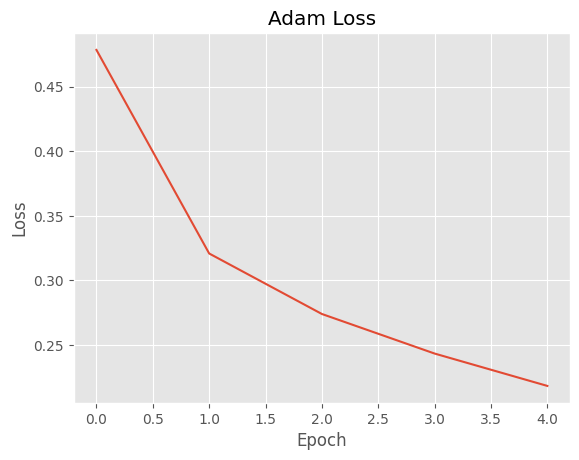

In [18]:
plot_loss(adam_history.history['loss'], 'Adam Loss')

## <font style="color:rgb(50,120,229)"> 6. Conclusiones </font>

### <font style="color:rgb(50,120,229)"> 6.1. Gráfica de pérdida en el conjunto de entrenamiento </font>

Al evaluar optimizadores, es importante estudiar la **pérdida** de entrenamiento para entender el comportamiento de convergencia en los datos de entrenamiento.

Recuerda que para un modelo y conjunto de datos dados, el trabajo del optimizador es rendir bien en los datos de entrenamiento.

<center>
    <img src="https://github.com/sofiapapadron/IME_IAA/blob/main/Teoria/2_Clasificacion_imagenes_Keras/3_Conceptos_avanzados_entrenamiento/ejercicios/images/loss.png?raw=1" width=1500>
</center>

Como se muestra en el gráfico anterior, SGD (rojo) tiene la pérdida más alta de los cuatro optimizadores, mientras que Adam (verde) eventualmente alcanza la pérdida más baja. Además, observa que SGD+Momentum (azul) sigue una tendencia muy similar a Adam, aunque no tan baja. Inicialmente, RMSProp (negro) converge más rápido en las primeras 10-15 épocas, pero si observas cuidadosamente, comienza a divergir después de aproximadamente 40-50 épocas, lo cual no es deseable.

Entonces, para este modelo y conjunto de datos, Adam claramente tiene el mejor rendimiento. Pero hay un par de advertencias. Primero, recuerda que en cada caso, utilizamos la tasa de aprendizaje predeterminada para cada optimizador, lo cual es algo bueno para hacer inicialmente.

Una vez que tengas una línea de base, puedes ajustar las tasas de aprendizaje para cada optimizador para ver cómo afecta eso a los resultados.

Aunque Adam generalmente funciona muy bien en una amplia gama de condiciones, no necesariamente es la mejor opción para todos los problemas, y al menos deberías experimentar inicialmente para ver qué optimizador parece ser el mejor. Una vez que seleccionas un optimizador, a menudo es necesario experimentar más para ajustar el entrenamiento de tu modelo.


### <font style="color:rgb(50,120,229)"> 6.1. Gráfica de pérdida en el conjunto de validación </font>

Aunque a menudo estudiamos la pérdida de validación al entrenar modelos, este no debería ser el criterio por el cual se selecciona un optimizador, ya que el trabajo del optimizador es lograr una convergencia rápida y estable en los datos de entrenamiento. Sin embargo, vale la pena estudiar la pérdida de validación en este caso para hacer algunos puntos.

<center>
    <img src="https://github.com/sofiapapadron/IME_IAA/blob/main/Teoria/2_Clasificacion_imagenes_Keras/3_Conceptos_avanzados_entrenamiento/ejercicios/images/valid.png?raw=1" width=1500>
</center>

En el gráfico anterior, primero notamos que la pérdida para tres optimizadores comienza a divergir después de aproximadamente 10-15 épocas. El optimizador SGD tarda más en converger, pero se aplana y realmente no parece divergir. Entonces, puede ser tentador concluir que SGD podría ser una buena elección. Pero nuevamente, debemos recordar que si bien la pérdida de validación es importante para ajustar finamente el modelo y los hiperparámetros para un optimizador dado, **este no debería ser el criterio por el cual se selecciona un optimizador.**

Pero si comparas estas curvas cuidadosamente, verás que Adam, SGD+Momentum y RMSProp alcanzan aproximadamente el mismo mínimo (pérdida de validación) en algún lugar entre 8 y 15 épocas, todos tienen una pérdida más baja que el optimizador SGD (rojo), que tarda mucho más en alcanzar su valor mínimo. Entonces, aunque no queremos usar la pérdida de validación como criterio para seleccionar el **tipo** de optimizador a utilizar, el hecho de que los otros tres optimizadores logren una pérdida más baja que SGD en solo unas pocas épocas es una buena indicación de que tienen mejores propiedades de convergencia que SGD.
